In [1]:
from torchvision import datasets, transforms
from data_utils import split_noniid
from torch.utils.data import Subset

In [2]:
#使用cifar10数据集
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.CIFAR10(root='cifar10', train=True,download=True, transform=trans)

Files already downloaded and verified


In [3]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 5.0

#client_idcs是包含n_clients子列表的列表,client_idcs[0]表示客户端0所拥有的数据index(已经处理成非iid的数据)
client_idcs = split_noniid(train_data,alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

#根据每个客户端的index，获取客户端对应的数据。
client_data = [Subset(train_data, idcs) for idcs in client_idcs]

对cifar10数据集进行处理。模拟10个客户端的场景，并根据参数为alpha=5.0的Dirichlet分布，以非独立同分布的方式将数据分配给客户端。数据的分布如下所示。

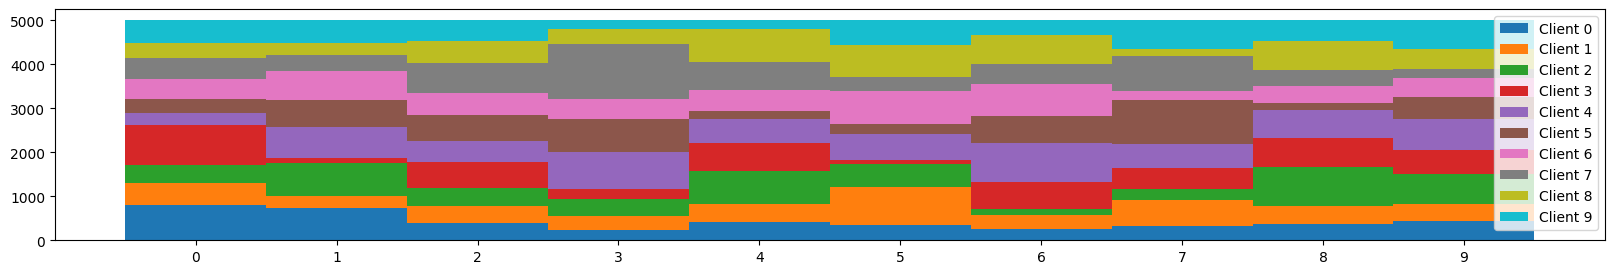

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

targets = torch.tensor(train_data.targets)
mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')
plt.figure(figsize=(20,3))
plt.hist([targets[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(targets)-0.5, max(train_data.targets) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])

plt.xticks(np.arange(10), mapp)
plt.legend()
plt.show()

In [5]:
from federated_device import Client,Server
from models import MobileNetV2
# 设置客户端模型参数
client_net=MobileNetV2(num_classes=10)
clients = [Client(client_net, data, client_id=i) for i, data in enumerate(client_data)]
# 设置客户端模型参数
server_net=MobileNetV2(num_classes=10)
server = Server(server_net)

Client 0:


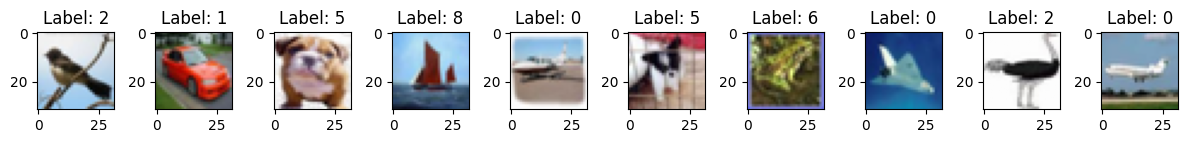

Client 6:


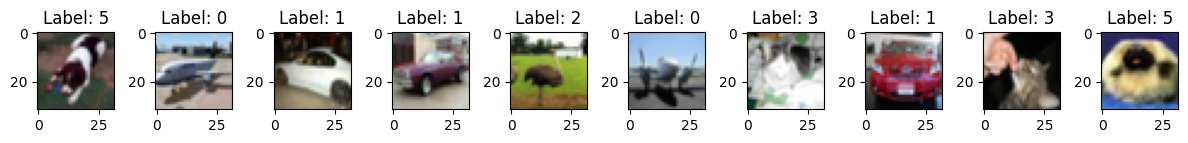

In [6]:
for client in [clients[0],clients[6]]:
    x, y = next(iter(client.Client_train_loader))
    print("Client {}:".format(client.Client_id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        normalized_image = (x[i].permute(1, 2, 0) - x[i].permute(1, 2, 0).min()) / (x[i].permute(1, 2, 0).max() - x[i].permute(1, 2, 0).min())
        plt.imshow(normalized_image.numpy())
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

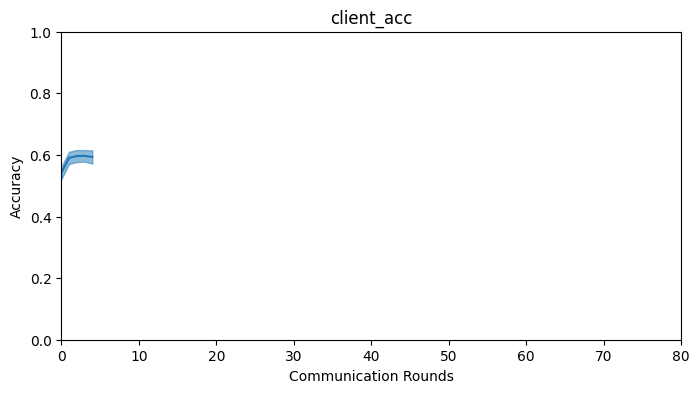

KeyboardInterrupt: 

In [7]:
from display import show_acc
from display import ExperimentLogger

client_acc_stats = ExperimentLogger()
#设置通信轮数，默认80轮
COMMUNICATION_ROUNDS = 80

for round in range(COMMUNICATION_ROUNDS):           
    #首先服务端确认参与的客户端数目
    participating_clients = server.select_clients(clients, frac=1.0)
    #如果是第一轮，则先与服务器同步
    if(round==0):
        for client in participating_clients:
            client.synchronize_with_server(server)
    
    #对于参与训练的客户端，在自己的数据集上开始训练，然后计算权重更新
    for client in participating_clients:
        client.compute_weight_update(epochs=5)
    
    #训练结束，上传客户端权重更新到服务器，进行聚合。
    server.aggregate_weight_updates(participating_clients)

    #对于参加训练的客户端，与服务器同步，接受最新的全局模型。
    for client in participating_clients:
        client.synchronize_with_server(server)

    #用最新的模型评估
    clients_acc = [client.eval() for client in participating_clients]

    client_acc_stats.log({"clients_acc" : clients_acc,"rounds" : round})
    show_acc(client_acc_stats, COMMUNICATION_ROUNDS)
 
server.cache_model([client.Client_id for client in participating_clients], clients_acc)


In [ ]:
# 评估未聚类模型和聚类后的模型的准确度
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [ ]:
#画图
import pandas as pd
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: black' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.555071,0.540073,0.526468,0.529228,0.559883,0.550249,0.505669,0.552533,0.546771,0.520646
